# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import random

# Hyperparameters

In [3]:
# Seed for reproducibility
manualSeed = 88

# Path to the zip file containing the image dataset
zip_file_path = "drive/MyDrive/GAN/dataset/animal_face.zip"

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size.
image_size = 64

# Number of channels in the training images.
n_channel = 3

# Size of z latent vector (i.e. size of generator input)
dim_z = 100

# LeakyRelu negative slope
slope = 0.2

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Choose gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup Reproducibility

In [4]:
random.seed(manualSeed)
torch.manual_seed(seed=manualSeed)
torch.use_deterministic_algorithms(True)
print(f"Seed: {manualSeed}")

Seed: 88


# Unzip Dataset

In [5]:
from zipfile import ZipFile

from tempfile import TemporaryDirectory

unzip_folder_path = TemporaryDirectory()

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder_path.name)
    print(f"dataset unzipped at {unzip_folder_path.name}")

dataset unzipped at /tmp/tmpjesa7uo8


# Load Dataset

In [6]:
img_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(unzip_folder_path.name, transform=img_transforms)

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset Length:{len(dataset)}")
print(f"Dataloader Length:{len(dataloader)}")

Dataset Length:16130
Dataloader Length:127


## Dataset Samples

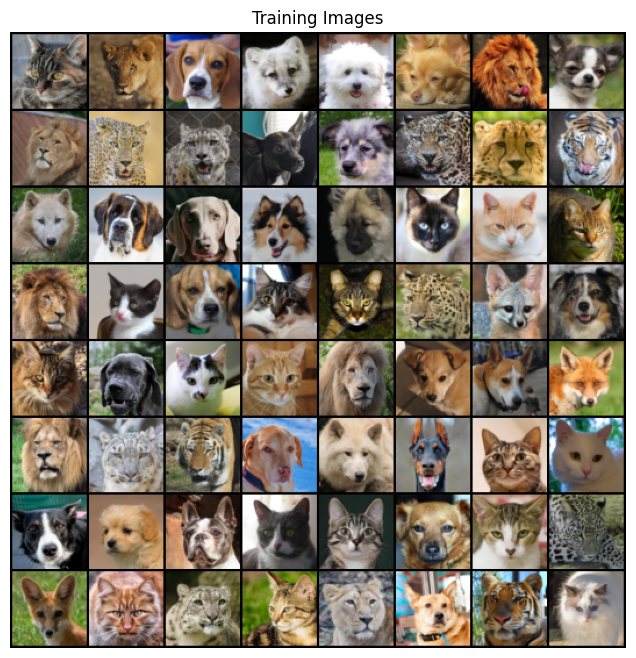

In [7]:
imgs, _ = next(iter(dataloader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(imgs.to(device)[:64], normalize=True).cpu(), (1,2,0)))
plt.show()

# Generator

In [8]:
# bias=False because the batchnorm will center the values
# so the bias of the previous layer will be cancelled by the batchnorm
class Generator(nn.Module):
    def __init__(self, latent_size, num_out_channel):
        super().__init__()

        self.net = nn.Sequential(
            self._block(latent_size, 512, 4, 1, 0),
            self._block(512, 256, 4, 2, 1),
            self._block(256, 128, 4, 2, 1),
            self._block(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, num_out_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def _block(self, in_channel, out_channel, kernel_size, stride_size, padding_size):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride_size, padding=padding_size, bias=False),
            nn.BatchNorm2d(num_features=out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, z):
        return self.net(z)

# Discriminator

In [9]:
# bias=False because the batchnorm will center the values
# so the bias of the previous layer will be cancelled by the batchnorm
class Discriminator(nn.Module):

    def __init__(self, img_channels, leakyrelu_slope):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(negative_slope=leakyrelu_slope, inplace=True),
            self._block(64, 128, 4, 2, 1, leakyrelu_slope),
            self._block(128, 256, 4, 2, 1, leakyrelu_slope),
            self._block(256, 512, 4, 2, 1, leakyrelu_slope),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def _block(self, in_channel, out_channel, kernel_size, stride_size, padding_size, leaky_slope):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride_size, padding=padding_size, bias=False),
            nn.BatchNorm2d(num_features=out_channel),
            nn.LeakyReLU(negative_slope=leaky_slope, inplace=True)
        )

    def forward(self, x):
        return self.net(x)

# Weight Initialization

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Initialization

In [11]:
netG = Generator(dim_z, n_channel).to(device)

netG.apply(weights_init)

print(netG)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Discriminator Initialization

In [12]:
netD = Discriminator(n_channel, slope).to(device)

netD.apply(weights_init)

print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_

# Loss Functions and Optimizers

In [13]:
loss = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Adversarial Training

In [14]:
G_losses = []
D_losses = []

real_label = 1.
fake_label = 0.

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()

        ## Train with all-real batch
        # Format batch
        imgs, _ = data
        real = imgs.to(device)
        n_imgs = real.size(0)
        label = torch.full((n_imgs,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss(output, label)
        # Calculate gradients for D on all-real batch
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(n_imgs, dim_z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        # Update G network: maximize log(D(G(z))) [Non-Saturating Loss]
        netG.zero_grad()
        # Fake labels are real for generator loss
        label.fill_(real_label)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss
        errG = loss(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        # Every 50 batch, show Discriminator and Generator Loss
        if i % 50 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f  Loss_G: %.4f'% (epoch, num_epochs-1, i, len(dataloader),errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[0/99][0/127]  Loss_D: 1.6394  Loss_G: 4.7306
[0/99][50/127]  Loss_D: 0.9091  Loss_G: 21.9412
[0/99][100/127]  Loss_D: 0.3082  Loss_G: 5.6419
[1/99][0/127]  Loss_D: 0.5644  Loss_G: 5.2145
[1/99][50/127]  Loss_D: 0.5926  Loss_G: 5.7192
[1/99][100/127]  Loss_D: 0.4982  Loss_G: 7.3246
[2/99][0/127]  Loss_D: 4.1090  Loss_G: 8.4405
[2/99][50/127]  Loss_D: 0.5654  Loss_G: 4.0199
[2/99][100/127]  Loss_D: 0.6507  Loss_G: 5.7431
[3/99][0/127]  Loss_D: 5.0643  Loss_G: 5.6141
[3/99][50/127]  Loss_D: 0.8074  Loss_G: 4.5300
[3/99][100/127]  Loss_D: 0.4765  Loss_G: 5.7568
[4/99][0/127]  Loss_D: 1.8681  Loss_G: 10.7418
[4/99][50/127]  Loss_D: 1.2192  Loss_G: 2.5320
[4/99][100/127]  Loss_D: 0.3897  Loss_G: 4.6098
[5/99][0/127]  Loss_D: 3.9048  Loss_G: 4.7325
[5/99][50/127]  Loss_D: 0.2611  Loss_G: 3.1868
[5/99][100/127]  Loss_D: 0.6672  Loss_G: 7.5529
[6/99][0/127]  Loss_D: 1.0979  Loss_G: 2.5080
[6/99][50/127]  Loss_D: 0.3662  Loss_G: 4.9144
[6/99][100/127]  Loss_D: 0.3296  

# Training Loss Plot

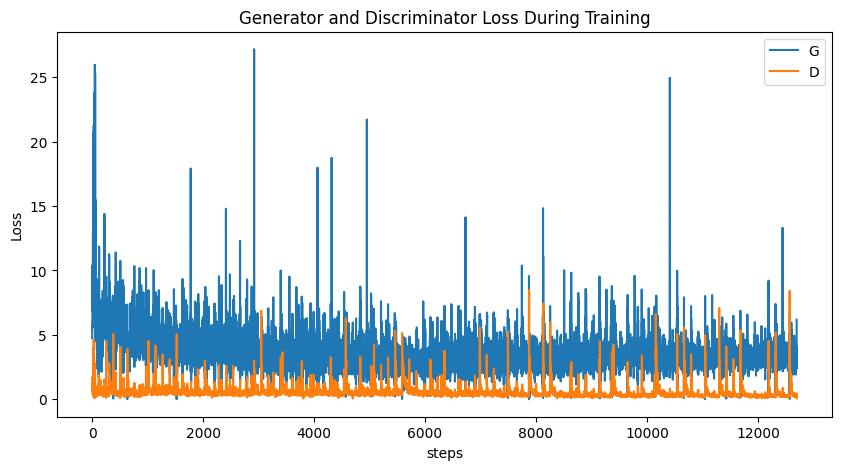

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Real vs Generated Images

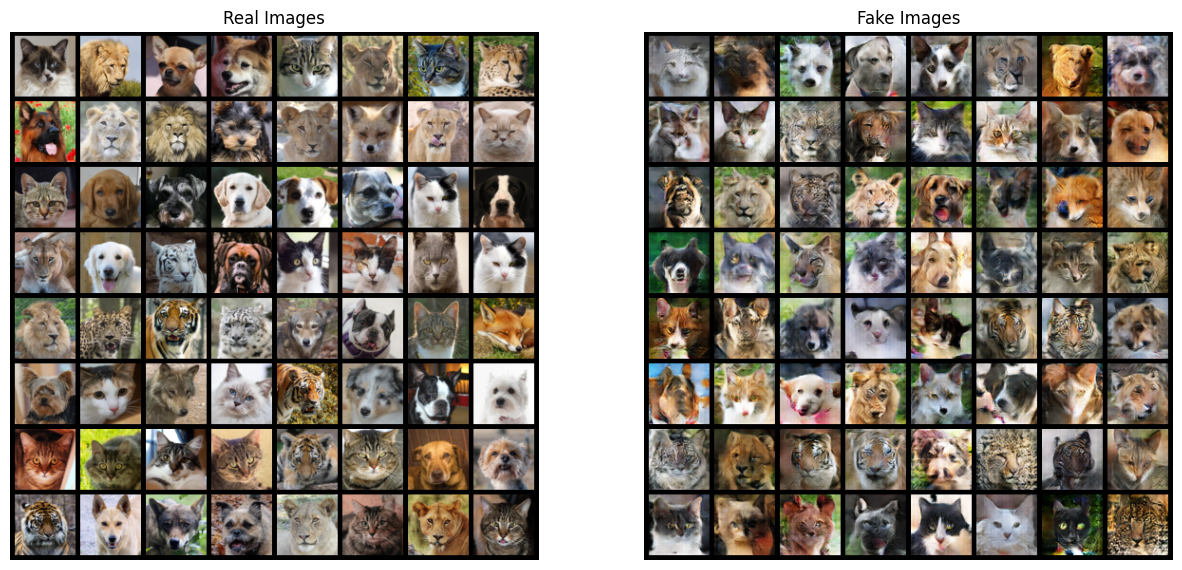

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generate fake images from the fitted generator
z = torch.randn(64, dim_z, 1, 1, device=device)
with torch.no_grad():
    fake_imgs = netG(z).detach().cpu()

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
# Shape before transpose: (3, 557, 557)
# Shape after transpose: (557, 557, 3)
plt.imshow(np.transpose(make_grid(fake_imgs, padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

# Save Generator & Discriminator

In [17]:
torch.save(netG.state_dict(), "generator_animal_face.pth")
torch.save(netD.state_dict(), "discriminator_animal_face.pth")

# Load Generator & Discriminator

In [18]:
generator = Generator(100, 3)
generator.load_state_dict(torch.load("generator_animal_face.pth", weights_only=True))


discriminator = Discriminator(3, 0.2)
discriminator.load_state_dict(torch.load("discriminator_animal_face.pth", weights_only=True))

<All keys matched successfully>

# Test Loaded Generator & Discriminator

tensor([0.5353, 0.2849, 0.1216, 0.2166, 0.0594, 0.0874, 0.2152, 0.0279, 0.0629,
        0.2437, 0.0420, 0.0223, 0.1363, 0.2799, 0.0364, 0.0355, 0.6083, 0.0460,
        0.0259, 0.2435, 0.0030, 0.0021, 0.0188, 0.1624, 0.2377, 0.0092, 0.0730,
        0.3449, 0.0042, 0.2416, 0.0113, 0.0563, 0.1240, 0.9090, 0.0088, 0.0254,
        0.0335, 0.0068, 0.2041, 0.0328, 0.0067, 0.1133, 0.1432, 0.0034, 0.1287,
        0.0670, 0.1819, 0.0469, 0.0208, 0.0897, 0.1102, 0.0179, 0.0083, 0.0961,
        0.0646, 0.1247, 0.0188, 0.1048, 0.0071, 0.1402, 0.0397, 0.0803, 0.0515])


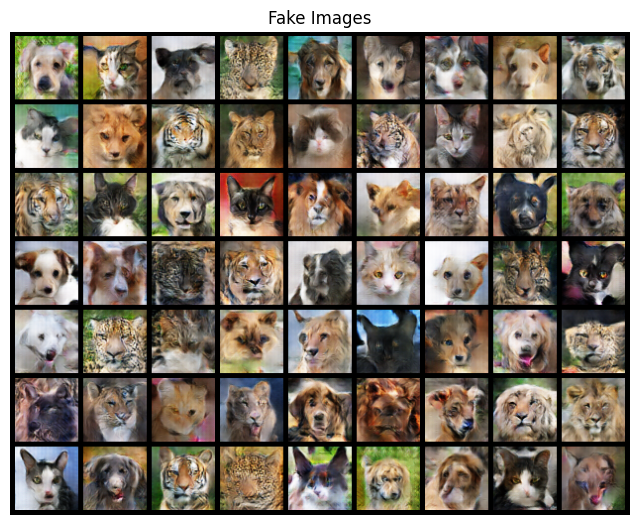

In [105]:
# Generate fake images from the loaded generator
z = torch.randn(63, dim_z, 1, 1, device="cpu")
generator.eval()
discriminator.eval()
with torch.no_grad():
    fake_imgs = generator(z)
    prediction = discriminator(fake_imgs).view(-1)

print(prediction)

# Plot the fake images

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(make_grid(fake_imgs, padding=5, nrow=9 ,normalize=True).cpu(),(1,2,0)))
plt.show()



# Cleanup

In [ ]:
# Delete temporary directory containing training images
unzip_folder_path.cleanup()